# Using linear regression to predict the joints
***

### Datasets: [subset](http://cims.nyu.edu/~tompson/flic_plus.htm) of full [FLIC](http://vision.grasp.upenn.edu/cgi-bin/index.php?n=VideoLearning.FLIC)
- Number of all the training images is 17380
    - Divided into validation sample 17380 * 20% = 3476
    - Divided into training sample 17380 - (17380 * 20%) = 13904
- Number of test images is 3548
- Number of joints is 7 (x, y)
    
### Data preprocessing
- Using the ground truth coordinates of joints to decide a bounding box (human detector)
- Add some noise (padding, shift) to the bounding box by uniform distribution
- Crop the original image acoording to the bounding box
- Resize the cropped image to 220x220

### Algorithm: Linear regression, **y** = **XW** + **b**, and y is a vector coordinates of joints
- Model
    - Build a linear model for every coordinate (x, y) of joints, i.e., 7*2=14 linear model in total
    - Use L2-norm loss (square error) $\sum_i^n (f(x_i) - y_i)^2$ for each model
    - The total loss is the sum of that for every model
    - We can regard all the models as a single Neural Network (no hidden layer) model with 14 output for regression
- Optimization
    - Use Stochastic gradient descent (SGD) to update weights and biases with batch size 32
    - Use num_epochs=100 to repeat the training and optimization.
- Test
    - Compute the loss of validation data at the end of each epoch
    - Plot the loss decay based on each epoch
    - Plot original, transformed and predicted joints on the image

### Some implementation details
- Use CPU on Mac OS X 10.10.3

- Memeory analysis
>If using 220 x 220 size, the number of input features (raw pixels) will be `220*220*3`, which will take ~0.00108 GB in python. So with 17380 training sets, it will take about 17380 * 0.00108 ~= 18GB memory. And if we resize image to 110x110, it will take about ~4.5GB.

- Multi-process
>Because I choose 220 x 220 size, it will not possible to load all the data before training. Therefore I need to read some batch of data into memory to train and optimize the model, then I should release the previous data from memory. It is not good because the training stage has to wait until new data are loaded into memory. I use multi-process to speed up the whole process(see figure below). Specifically, the fist process is to read batch_size data from disk and store them in a Queue. The other one is to get batch_size of data from Queue and performs training and optimization. Following is the stucture of multi-process.

<img src="other_material/multiprocess_structure.png" width="600"/> 
      
### A little summary of this experiment
    
- Training time
>It takes ~6 hours to training for 100 epochs. It wastes much time during reading data from disk to memory because it has to read each image and transform it from disk to memory for each epoch.

- Loss decay ([refer to figures below](#loss_curve))
>At beginning of the training, we can observe that the loss of training is higher than that of validation. This is because the loss is the average loss of different batches of training data and the parameters (weights) of the model are different, specifically we use one batch of data to compute the loss and gradient, then update the weights of model. However, we use the same trained model at the end of each epoch to compute the loss of each batch of validation data.

- Training loss vs Validation loss
>Another observation is that the validation loss is a little higher than training loss after around 20 epochs, however, the gap between the two curves is not obvious and overfitting is not a problem for this linear regression model. In general, the validation loss tracks the training loss fairly well, which means that our model capacity is not high enough and indicates that we need set up more complex model. For example, we can add more layers into that model.

- Generalization ([refer to images below](#show_joints))
>I use the same trained model to predict joints of the same original image several times and the only difference is the noise of bounding box (different padding and shift), however the variation of prediction is very big. This is because every weight is corresponding to the location, i.e.(x, y), of each pixel. So when the transformed image is shifted a little bit, it is not a big deal for our human's eyes, however our model can capture the tiny difference and the weights are associated with exactly different pixels. In order to imporve the prediction, it may be better to use a small patch of pixels instead of a single pixels alone (This is the basic idea of convolutional neural network). Other choice is using human-designed features such [SIFT features](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=790410&tag=1).

- Other observations
    - It makes prediction harder when the person in the picture wears black clothes. 
    - The model always predicts left joints as right joints when the person in the image turns his/her back to us.

In [44]:
# A bit of setup
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare for training

In [3]:
# set up fransform parameters to find the bounding box, crop and resize the images
# transfrom parameters
from my_scripts.transform import Transform
pad_inf = 1 # infimum scale
pad_sup = 1.5 # supremum scale
size = 220 # resize size
shift = 3 # radomly shift the bounding box
lcn = True # local contrast normalization
trans = Transform(pad_inf, pad_sup, size=size, shift=shift, lcn=lcn)

In [3]:
# set up the model and trainer for training
from my_scripts.regressor_trainer import NetworkTrainer
from models.LinearNet_flic import LinearNet_flic

data_dir = 'data/FLIC-full' # store image 
data_info_file = '%s/train_joints.csv' % data_dir # store corrdinates of joints for training data
model = LinearNet_flic(size)
trainer = NetworkTrainer(data_dir=data_dir, data_info_file=data_info_file, model=model, trans=trans)

In [4]:
# Training
best_model, train_loss_history, val_loss_history = trainer.train()

17380
Number of training data 13904
Number of validation data 3476
{'weight_decay': 0.0001, 'data_dir': 'data/FLIC-full', 'verbose': True, 'data_info_file': 'data/FLIC-full/train_joints.csv', 'sample_batches': True, 'learning_rate': 0.0001, 'update': 'MomentumSGD', 'batch_size': 32, 'reg': 0.0, 'self': <my_scripts.regressor_trainer.NetworkTrainer object at 0x10dc0e850>, 'snapshot': 5, 'val_rate': 0.2, 'num_epochs': 100, 'gpu': -1, 'model': <models.LinearNet_flic.LinearNet_flic object at 0x10dbfafd0>, 'trans': <my_scripts.transform.Transform object at 0x1073224d0>, 'dropout': 1.0, 'momentum': 0}


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:15 ETA:  0:00:00

epoch01	training mean loss =0.350061587828	 elapsed time=136.526004076 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:15 Time: 0:02:15
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:34 Time: 0:00:34
Saving 11.0 x 8.0 in image.


epoch01	validation mean loss =0.26033017835	 elapsed time=35.1776649952 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:17 ETA:  0:00:00

epoch02	training mean loss =0.232255213208	 elapsed time=138.763173103 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:17 Time: 0:02:17
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:32 Time: 0:00:32
Saving 11.0 x 8.0 in image.


epoch02	validation mean loss =0.21649753776	 elapsed time=32.9827680588 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:16 ETA:  0:00:00

epoch03	training mean loss =0.199432463211	 elapsed time=137.404169798 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:16 Time: 0:02:16
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch03	validation mean loss =0.194011629566	 elapsed time=35.7641320229 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch04	training mean loss =0.181635527299	 elapsed time=150.356453896 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch04	validation mean loss =0.174588951775	 elapsed time=35.6844580173 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch05	training mean loss =0.169048301578	 elapsed time=149.526980162 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch05	validation mean loss =0.169227451816	 elapsed time=35.5311059952 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch06	training mean loss =0.158859348067	 elapsed time=150.772178888 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch06	validation mean loss =0.156761594272	 elapsed time=35.9599440098 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:31 ETA:  0:00:00

epoch07	training mean loss =0.150285106089	 elapsed time=152.115424156 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:31 Time: 0:02:31
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch07	validation mean loss =0.148559213721	 elapsed time=35.5342230797 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch08	training mean loss =0.145326526745	 elapsed time=149.515531063 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch08	validation mean loss =0.142461757227	 elapsed time=35.7987499237 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:33 ETA:  0:00:00

epoch09	training mean loss =0.139195518043	 elapsed time=154.449424982 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:33 Time: 0:02:33
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:36 Time: 0:00:36
Saving 11.0 x 8.0 in image.


epoch09	validation mean loss =0.141418898589	 elapsed time=36.7500369549 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch10	training mean loss =0.134817245609	 elapsed time=150.49198103 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch10	validation mean loss =0.138824355953	 elapsed time=35.8793771267 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:33 ETA:  0:00:00

epoch11	training mean loss =0.130755263077	 elapsed time=154.442692041 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:33 Time: 0:02:33
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:36 Time: 0:00:36
Saving 11.0 x 8.0 in image.


epoch11	validation mean loss =0.130799488606	 elapsed time=36.8448288441 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:31 ETA:  0:00:00

epoch12	training mean loss =0.126808728258	 elapsed time=152.762260914 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:31 Time: 0:02:31
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch12	validation mean loss =0.127554846714	 elapsed time=35.8928749561 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch13	training mean loss =0.124639620684	 elapsed time=150.120503902 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch13	validation mean loss =0.124245795471	 elapsed time=35.6812448502 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch14	training mean loss =0.120898830623	 elapsed time=151.916669846 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch14	validation mean loss =0.122206663999	 elapsed time=35.7763979435 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:32 ETA:  0:00:00

epoch15	training mean loss =0.120185220246	 elapsed time=153.236612082 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:32 Time: 0:02:32
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch15	validation mean loss =0.119504956478	 elapsed time=35.71448493 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch16	training mean loss =0.116570031805	 elapsed time=150.387610197 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:36 Time: 0:00:36
Saving 11.0 x 8.0 in image.


epoch16	validation mean loss =0.117367614259	 elapsed time=36.5450780392 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch17	training mean loss =0.114394561254	 elapsed time=150.919817209 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch17	validation mean loss =0.11410346317	 elapsed time=35.8730041981 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch18	training mean loss =0.112350888943	 elapsed time=150.225081921 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:34 Time: 0:00:34
Saving 11.0 x 8.0 in image.


epoch18	validation mean loss =0.112901938326	 elapsed time=35.4818959236 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch19	training mean loss =0.109951416458	 elapsed time=150.040705919 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch19	validation mean loss =0.111372964733	 elapsed time=35.7827990055 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch20	training mean loss =0.108498593198	 elapsed time=149.571087122 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch20	validation mean loss =0.110000508096	 elapsed time=35.8304607868 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:31 ETA:  0:00:00

epoch21	training mean loss =0.106658698708	 elapsed time=152.038532019 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:31 Time: 0:02:31
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch21	validation mean loss =0.105635117559	 elapsed time=36.1502850056 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch22	training mean loss =0.105003945956	 elapsed time=151.025322199 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch22	validation mean loss =0.106942527118	 elapsed time=35.7276210785 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch23	training mean loss =0.103404355375	 elapsed time=150.798894882 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch23	validation mean loss =0.105430493133	 elapsed time=36.4039018154 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch24	training mean loss =0.102352394869	 elapsed time=151.230304003 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch24	validation mean loss =0.102087998279	 elapsed time=36.0710911751 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch25	training mean loss =0.101524102356	 elapsed time=149.93013382 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch25	validation mean loss =0.101209635615	 elapsed time=35.6000659466 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch26	training mean loss =0.100592549209	 elapsed time=151.335474014 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch26	validation mean loss =0.101578822184	 elapsed time=35.9315869808 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch27	training mean loss =0.0986022834592	 elapsed time=149.977087021 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch27	validation mean loss =0.0991002593311	 elapsed time=35.6194839478 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch28	training mean loss =0.0969873424367	 elapsed time=149.835087061 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch28	validation mean loss =0.0997323712202	 elapsed time=35.9385349751 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch29	training mean loss =0.0964759395173	 elapsed time=150.134870052 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch29	validation mean loss =0.0985899791832	 elapsed time=36.028329134 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:32 ETA:  0:00:00

epoch30	training mean loss =0.0957906905058	 elapsed time=153.174994946 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:32 Time: 0:02:32
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch30	validation mean loss =0.0957659962926	 elapsed time=35.6193060875 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch31	training mean loss =0.0936037175443	 elapsed time=151.414529085 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch31	validation mean loss =0.0969834404105	 elapsed time=36.2274429798 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch32	training mean loss =0.0937698955372	 elapsed time=151.110674143 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch32	validation mean loss =0.0965024637637	 elapsed time=35.5842690468 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch33	training mean loss =0.092505044435	 elapsed time=151.997162104 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch33	validation mean loss =0.0938405414465	 elapsed time=36.3654592037 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch34	training mean loss =0.0915842334367	 elapsed time=151.509331942 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch34	validation mean loss =0.0928763892216	 elapsed time=36.0164029598 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch35	training mean loss =0.0909440658925	 elapsed time=150.347635031 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch35	validation mean loss =0.0917938966051	 elapsed time=35.7391061783 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch36	training mean loss =0.0907433314868	 elapsed time=151.286030769 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch36	validation mean loss =0.0932971579523	 elapsed time=35.9055850506 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch37	training mean loss =0.0896227459843	 elapsed time=151.618961096 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch37	validation mean loss =0.0916181895437	 elapsed time=36.1658918858 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch38	training mean loss =0.089146702845	 elapsed time=151.273231983 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch38	validation mean loss =0.0907075608061	 elapsed time=35.5882229805 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch39	training mean loss =0.0883617110358	 elapsed time=149.084521055 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch39	validation mean loss =0.0894814464388	 elapsed time=35.6381020546 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:27 ETA:  0:00:00

epoch40	training mean loss =0.0881595951464	 elapsed time=148.550833941 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:27 Time: 0:02:27
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:34 Time: 0:00:34
Saving 11.0 x 8.0 in image.


epoch40	validation mean loss =0.0899073071234	 elapsed time=35.1519641876 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch41	training mean loss =0.0871247224332	 elapsed time=151.228316069 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:34 Time: 0:00:34
Saving 11.0 x 8.0 in image.


epoch41	validation mean loss =0.0878790474271	 elapsed time=35.260518074 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch42	training mean loss =0.0865078528135	 elapsed time=149.053375006 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:34 Time: 0:00:34
Saving 11.0 x 8.0 in image.


epoch42	validation mean loss =0.0874979521454	 elapsed time=35.4513349533 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:28 ETA:  0:00:00

epoch43	training mean loss =0.0857687468586	 elapsed time=149.590180159 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:28 Time: 0:02:28
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch43	validation mean loss =0.0855178583133	 elapsed time=35.6282608509 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:31 ETA:  0:00:00

epoch44	training mean loss =0.0842833065492	 elapsed time=152.761126995 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:31 Time: 0:02:31
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch44	validation mean loss =0.0849110069893	 elapsed time=35.720058918 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:31 ETA:  0:00:00

epoch45	training mean loss =0.0842664025933	 elapsed time=152.615989923 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:31 Time: 0:02:31
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch45	validation mean loss =0.0852120689358	 elapsed time=35.9133059978 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch46	training mean loss =0.0829382231001	 elapsed time=150.931259155 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37
Saving 11.0 x 8.0 in image.


epoch46	validation mean loss =0.0858754395864	 elapsed time=38.5602788925 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:30 ETA:  0:00:00

epoch47	training mean loss =0.0829733691782	 elapsed time=151.426944971 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:30 Time: 0:02:30
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch47	validation mean loss =0.0833951091251	 elapsed time=35.6574139595 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:29 ETA:  0:00:00

epoch48	training mean loss =0.0831584428229	 elapsed time=150.727502108 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:29 Time: 0:02:29
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch48	validation mean loss =0.0818285399048	 elapsed time=36.2476730347 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:48 ETA:  0:00:00

epoch49	training mean loss =0.0823705338238	 elapsed time=169.239526987 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:48 Time: 0:02:48
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:39 Time: 0:00:39
Saving 11.0 x 8.0 in image.


epoch49	validation mean loss =0.083430302518	 elapsed time=40.1164910793 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch50	training mean loss =0.080867534153	 elapsed time=184.72779417 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:43 Time: 0:00:43
Saving 11.0 x 8.0 in image.


epoch50	validation mean loss =0.0830999388357	 elapsed time=43.7516698837 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch51	training mean loss =0.0812858517151	 elapsed time=184.919461012 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:44 Time: 0:00:44
Saving 11.0 x 8.0 in image.


epoch51	validation mean loss =0.0808190625695	 elapsed time=44.9091961384 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:02 ETA:  0:00:00

epoch52	training mean loss =0.0806647397596	 elapsed time=183.902956009 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:02 Time: 0:03:02
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:43 Time: 0:00:43
Saving 11.0 x 8.0 in image.


epoch52	validation mean loss =0.0823856053828	 elapsed time=44.3463380337 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:07 ETA:  0:00:00

epoch53	training mean loss =0.0806612453181	 elapsed time=188.967828035 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:07 Time: 0:03:07
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:43 Time: 0:00:43
Saving 11.0 x 8.0 in image.


epoch53	validation mean loss =0.081909716612	 elapsed time=44.4679269791 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch54	training mean loss =0.0797668921596	 elapsed time=184.297208071 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch54	validation mean loss =0.0816108001254	 elapsed time=42.2983930111 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:57 ETA:  0:00:00

epoch55	training mean loss =0.0794629374774	 elapsed time=178.342767954 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:57 Time: 0:02:57
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:42 Time: 0:00:42
Saving 11.0 x 8.0 in image.


epoch55	validation mean loss =0.0817065967978	 elapsed time=42.6238811016 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:55 ETA:  0:00:00

epoch56	training mean loss =0.078546202701	 elapsed time=176.262542009 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:55 Time: 0:02:55
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch56	validation mean loss =0.0797789634455	 elapsed time=42.1260461807 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:58 ETA:  0:00:00

epoch57	training mean loss =0.0784792530493	 elapsed time=179.801510811 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:58 Time: 0:02:58
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch57	validation mean loss =0.0788125469709	 elapsed time=42.1108820438 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:57 ETA:  0:00:00

epoch58	training mean loss =0.0774962099964	 elapsed time=179.109097004 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:57 Time: 0:02:57
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch58	validation mean loss =0.0795030370421	 elapsed time=42.1801650524 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch59	training mean loss =0.0770645409971	 elapsed time=184.60149622 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch59	validation mean loss =0.0781274953609	 elapsed time=42.1472702026 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:01 ETA:  0:00:00

epoch60	training mean loss =0.0772571876205	 elapsed time=182.758924961 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:01 Time: 0:03:01
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:42 Time: 0:00:42
Saving 11.0 x 8.0 in image.


epoch60	validation mean loss =0.0779546195539	 elapsed time=42.8031389713 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch61	training mean loss =0.0770744159863	 elapsed time=184.293750048 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:42 Time: 0:00:42
Saving 11.0 x 8.0 in image.


epoch61	validation mean loss =0.0782470590303	 elapsed time=43.0683498383 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:01 ETA:  0:00:00

epoch62	training mean loss =0.0759570378538	 elapsed time=182.885844946 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:01 Time: 0:03:01
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch62	validation mean loss =0.0763743242854	 elapsed time=42.0515229702 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:01 ETA:  0:00:00

epoch63	training mean loss =0.0763181826828	 elapsed time=182.585499048 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:01 Time: 0:03:01
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:40 Time: 0:00:40
Saving 11.0 x 8.0 in image.


epoch63	validation mean loss =0.0763402826487	 elapsed time=41.5607471466 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:00 ETA:  0:00:00

epoch64	training mean loss =0.0757047909256	 elapsed time=181.437146902 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:00 Time: 0:03:00
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch64	validation mean loss =0.0765322433334	 elapsed time=42.0403978825 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch65	training mean loss =0.0753342787738	 elapsed time=184.754111052 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:52 Time: 0:00:52
Saving 11.0 x 8.0 in image.


epoch65	validation mean loss =0.0771924273557	 elapsed time=53.5019278526 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:52 ETA:  0:00:00

epoch66	training mean loss =0.0748755953341	 elapsed time=173.470646858 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:52 Time: 0:02:52
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37
Saving 11.0 x 8.0 in image.


epoch66	validation mean loss =0.0765424380064	 elapsed time=38.2652699947 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:45 ETA:  0:00:00

epoch67	training mean loss =0.0745728678871	 elapsed time=166.242618799 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:45 Time: 0:02:45
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37
Saving 11.0 x 8.0 in image.


epoch67	validation mean loss =0.0743043671993	 elapsed time=38.2459340096 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:42 ETA:  0:00:00

epoch68	training mean loss =0.0738209462514	 elapsed time=163.484808207 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:42 Time: 0:02:42
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch68	validation mean loss =0.0752868922353	 elapsed time=39.1491880417 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:41 ETA:  0:00:00

epoch69	training mean loss =0.074329782818	 elapsed time=162.274828911 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:41 Time: 0:02:41
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:40 Time: 0:00:40
Saving 11.0 x 8.0 in image.


epoch69	validation mean loss =0.0736871003392	 elapsed time=41.0445418358 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:00 ETA:  0:00:00

epoch70	training mean loss =0.0741108077898	 elapsed time=181.084563971 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:00 Time: 0:03:00
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:40 Time: 0:00:40
Saving 11.0 x 8.0 in image.


epoch70	validation mean loss =0.0758207145938	 elapsed time=40.6531398296 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:09 ETA:  0:00:00

epoch71	training mean loss =0.0734345356902	 elapsed time=190.737567186 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:09 Time: 0:03:09
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:43 Time: 0:00:43
Saving 11.0 x 8.0 in image.


epoch71	validation mean loss =0.0759525145245	 elapsed time=44.1395578384 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:20 ETA:  0:00:00

epoch72	training mean loss =0.0727007374004	 elapsed time=202.040230036 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:20 Time: 0:03:20
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:45 Time: 0:00:45
Saving 11.0 x 8.0 in image.


epoch72	validation mean loss =0.0755189118061	 elapsed time=45.9113359451 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:59 ETA:  0:00:00

epoch73	training mean loss =0.0729659010811	 elapsed time=180.09838891 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:59 Time: 0:02:59
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:39 Time: 0:00:39
Saving 11.0 x 8.0 in image.


epoch73	validation mean loss =0.0745374570621	 elapsed time=40.2363801003 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:54 ETA:  0:00:00

epoch74	training mean loss =0.0719505592707	 elapsed time=175.160306931 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:54 Time: 0:02:54
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:42 Time: 0:00:42
Saving 11.0 x 8.0 in image.


epoch74	validation mean loss =0.0744444693986	 elapsed time=42.9130151272 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:44 ETA:  0:00:00

epoch75	training mean loss =0.0717413013058	 elapsed time=165.636291981 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:44 Time: 0:02:44
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch75	validation mean loss =0.0747962786707	 elapsed time=39.4085988998 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:04 ETA:  0:00:00

epoch76	training mean loss =0.0721477930846	 elapsed time=185.818789005 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:04 Time: 0:03:04
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37
Saving 11.0 x 8.0 in image.


epoch76	validation mean loss =0.0734211427314	 elapsed time=38.3251950741 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:39 ETA:  0:00:00

epoch77	training mean loss =0.0710051713976	 elapsed time=160.870074034 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:39 Time: 0:02:39
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch77	validation mean loss =0.0745370639204	 elapsed time=38.6708078384 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:38 ETA:  0:00:00

epoch78	training mean loss =0.0714737490377	 elapsed time=159.605376005 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:38 Time: 0:02:38
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:36 Time: 0:00:36
Saving 11.0 x 8.0 in image.


epoch78	validation mean loss =0.0720846477224	 elapsed time=37.1657750607 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:38 ETA:  0:00:00

epoch79	training mean loss =0.0713512107597	 elapsed time=159.542169094 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:38 Time: 0:02:38
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:36 Time: 0:00:36
Saving 11.0 x 8.0 in image.


epoch79	validation mean loss =0.0719081359899	 elapsed time=36.5937309265 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:33 ETA:  0:00:00

epoch80	training mean loss =0.0713114445941	 elapsed time=155.103441 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:33 Time: 0:02:33
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch80	validation mean loss =0.0724485615671	 elapsed time=38.5913619995 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:40 ETA:  0:00:00

epoch81	training mean loss =0.0708192018441	 elapsed time=161.355732918 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:40 Time: 0:02:40
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37
Saving 11.0 x 8.0 in image.


epoch81	validation mean loss =0.0713018104141	 elapsed time=38.4213998318 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:52 ETA:  0:00:00

epoch82	training mean loss =0.0698743955396	 elapsed time=174.074577808 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:52 Time: 0:02:52
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:40 Time: 0:00:40
Saving 11.0 x 8.0 in image.


epoch82	validation mean loss =0.0705137510491	 elapsed time=41.5299830437 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:03 ETA:  0:00:00

epoch83	training mean loss =0.069899385421	 elapsed time=184.53547287 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:03 Time: 0:03:03
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:39 Time: 0:00:39
Saving 11.0 x 8.0 in image.


epoch83	validation mean loss =0.0715269089299	 elapsed time=39.8770809174 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:41 ETA:  0:00:00

epoch84	training mean loss =0.0700048081866	 elapsed time=163.055305958 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:41 Time: 0:02:41
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch84	validation mean loss =0.0704092609767	 elapsed time=39.5059859753 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:45 ETA:  0:00:00

epoch85	training mean loss =0.0685318380994	 elapsed time=166.82810092 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:45 Time: 0:02:45
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:42 Time: 0:00:42
Saving 11.0 x 8.0 in image.


epoch85	validation mean loss =0.069370510223	 elapsed time=43.3959109783 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:43 ETA:  0:00:00

epoch86	training mean loss =0.0694232815566	 elapsed time=164.402697086 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:43 Time: 0:02:43
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:42 Time: 0:00:42
Saving 11.0 x 8.0 in image.


epoch86	validation mean loss =0.0690170803134	 elapsed time=42.5554838181 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:03:13 ETA:  0:00:00

epoch87	training mean loss =0.0686854686587	 elapsed time=195.120584965 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:03:13 Time: 0:03:13
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:45 Time: 0:00:45
Saving 11.0 x 8.0 in image.


epoch87	validation mean loss =0.0713604924546	 elapsed time=46.3315420151 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:43 ETA:  0:00:00

epoch88	training mean loss =0.0689776048219	 elapsed time=164.723767042 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:43 Time: 0:02:43
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch88	validation mean loss =0.07091095652	 elapsed time=38.856128931 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:40 ETA:  0:00:00

epoch89	training mean loss =0.0681230998467	 elapsed time=162.037048101 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:40 Time: 0:02:40
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch89	validation mean loss =0.0696343628136	 elapsed time=42.3597838879 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:50 ETA:  0:00:00

epoch90	training mean loss =0.0678732522847	 elapsed time=171.647531033 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:50 Time: 0:02:50
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:40 Time: 0:00:40
Saving 11.0 x 8.0 in image.


epoch90	validation mean loss =0.0686709913373	 elapsed time=40.8067631721 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:44 ETA:  0:00:00

epoch91	training mean loss =0.0675893020248	 elapsed time=165.648370981 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:44 Time: 0:02:44
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch91	validation mean loss =0.0690668017665	 elapsed time=38.5788018703 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:50 ETA:  0:00:00

epoch92	training mean loss =0.0673226304738	 elapsed time=172.093441963 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:50 Time: 0:02:50
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:40 Time: 0:00:40
Saving 11.0 x 8.0 in image.


epoch92	validation mean loss =0.0678852166352	 elapsed time=40.5593590736 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:58 ETA:  0:00:00

epoch93	training mean loss =0.0674180746526	 elapsed time=179.635847807 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:58 Time: 0:02:58
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:43 Time: 0:00:43
Saving 11.0 x 8.0 in image.


epoch93	validation mean loss =0.0689259749279	 elapsed time=43.6739730835 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:49 ETA:  0:00:00

epoch94	training mean loss =0.0671403493959	 elapsed time=170.707660913 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:49 Time: 0:02:49
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:43 Time: 0:00:43
Saving 11.0 x 8.0 in image.


epoch94	validation mean loss =0.069720823406	 elapsed time=43.9746010303 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:51 ETA:  0:00:00

epoch95	training mean loss =0.0667996965179	 elapsed time=172.435247898 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:51 Time: 0:02:51
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:39 Time: 0:00:39
Saving 11.0 x 8.0 in image.


epoch95	validation mean loss =0.0685022783303	 elapsed time=40.3350069523 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:56 ETA:  0:00:00

epoch96	training mean loss =0.066718090187	 elapsed time=177.918204069 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:56 Time: 0:02:56
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:38 Time: 0:00:38
Saving 11.0 x 8.0 in image.


epoch96	validation mean loss =0.0665491258156	 elapsed time=38.8639910221 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:46 ETA:  0:00:00

epoch97	training mean loss =0.0663246941742	 elapsed time=167.677883863 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:46 Time: 0:02:46
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:39 Time: 0:00:39
Saving 11.0 x 8.0 in image.


epoch97	validation mean loss =0.0684139431846	 elapsed time=39.8400089741 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:46 ETA:  0:00:00

epoch98	training mean loss =0.0663533227208	 elapsed time=167.736859083 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:46 Time: 0:02:46
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:41 Time: 0:00:41
Saving 11.0 x 8.0 in image.


epoch98	validation mean loss =0.0672061308649	 elapsed time=41.773086071 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:54 ETA:  0:00:00

epoch99	training mean loss =0.0661600837808	 elapsed time=175.23220706 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:54 Time: 0:02:54
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37
Saving 11.0 x 8.0 in image.


epoch99	validation mean loss =0.0677856355809	 elapsed time=37.911550045 sec.
adfadss


 99% (13888 of 13904) |################## | Elapsed Time: 0:02:32 ETA:  0:00:00

epoch100	training mean loss =0.0661680850447	 elapsed time=153.263383865 sec.


100% (13904 of 13904) |###################| Elapsed Time: 0:02:32 Time: 0:02:32
100% (3476 of 3476) |#####################| Elapsed Time: 0:00:35 Time: 0:00:35
Saving 11.0 x 8.0 in image.


epoch100	validation mean loss =0.0681589488573	 elapsed time=36.2853829861 sec.
adfadss


## Store the trained results with pickle

In [56]:
import cPickle as pickle
trained_results = 'results/LinearNet_flic_2015-07-27-12-14-37/trained_resutls.chainer'
pickle.dump((best_model, train_loss_history, val_loss_history), open(trained_results, 'wb'), -1)

<a name='loss_curve'></a>
## Show the loss curve during the training

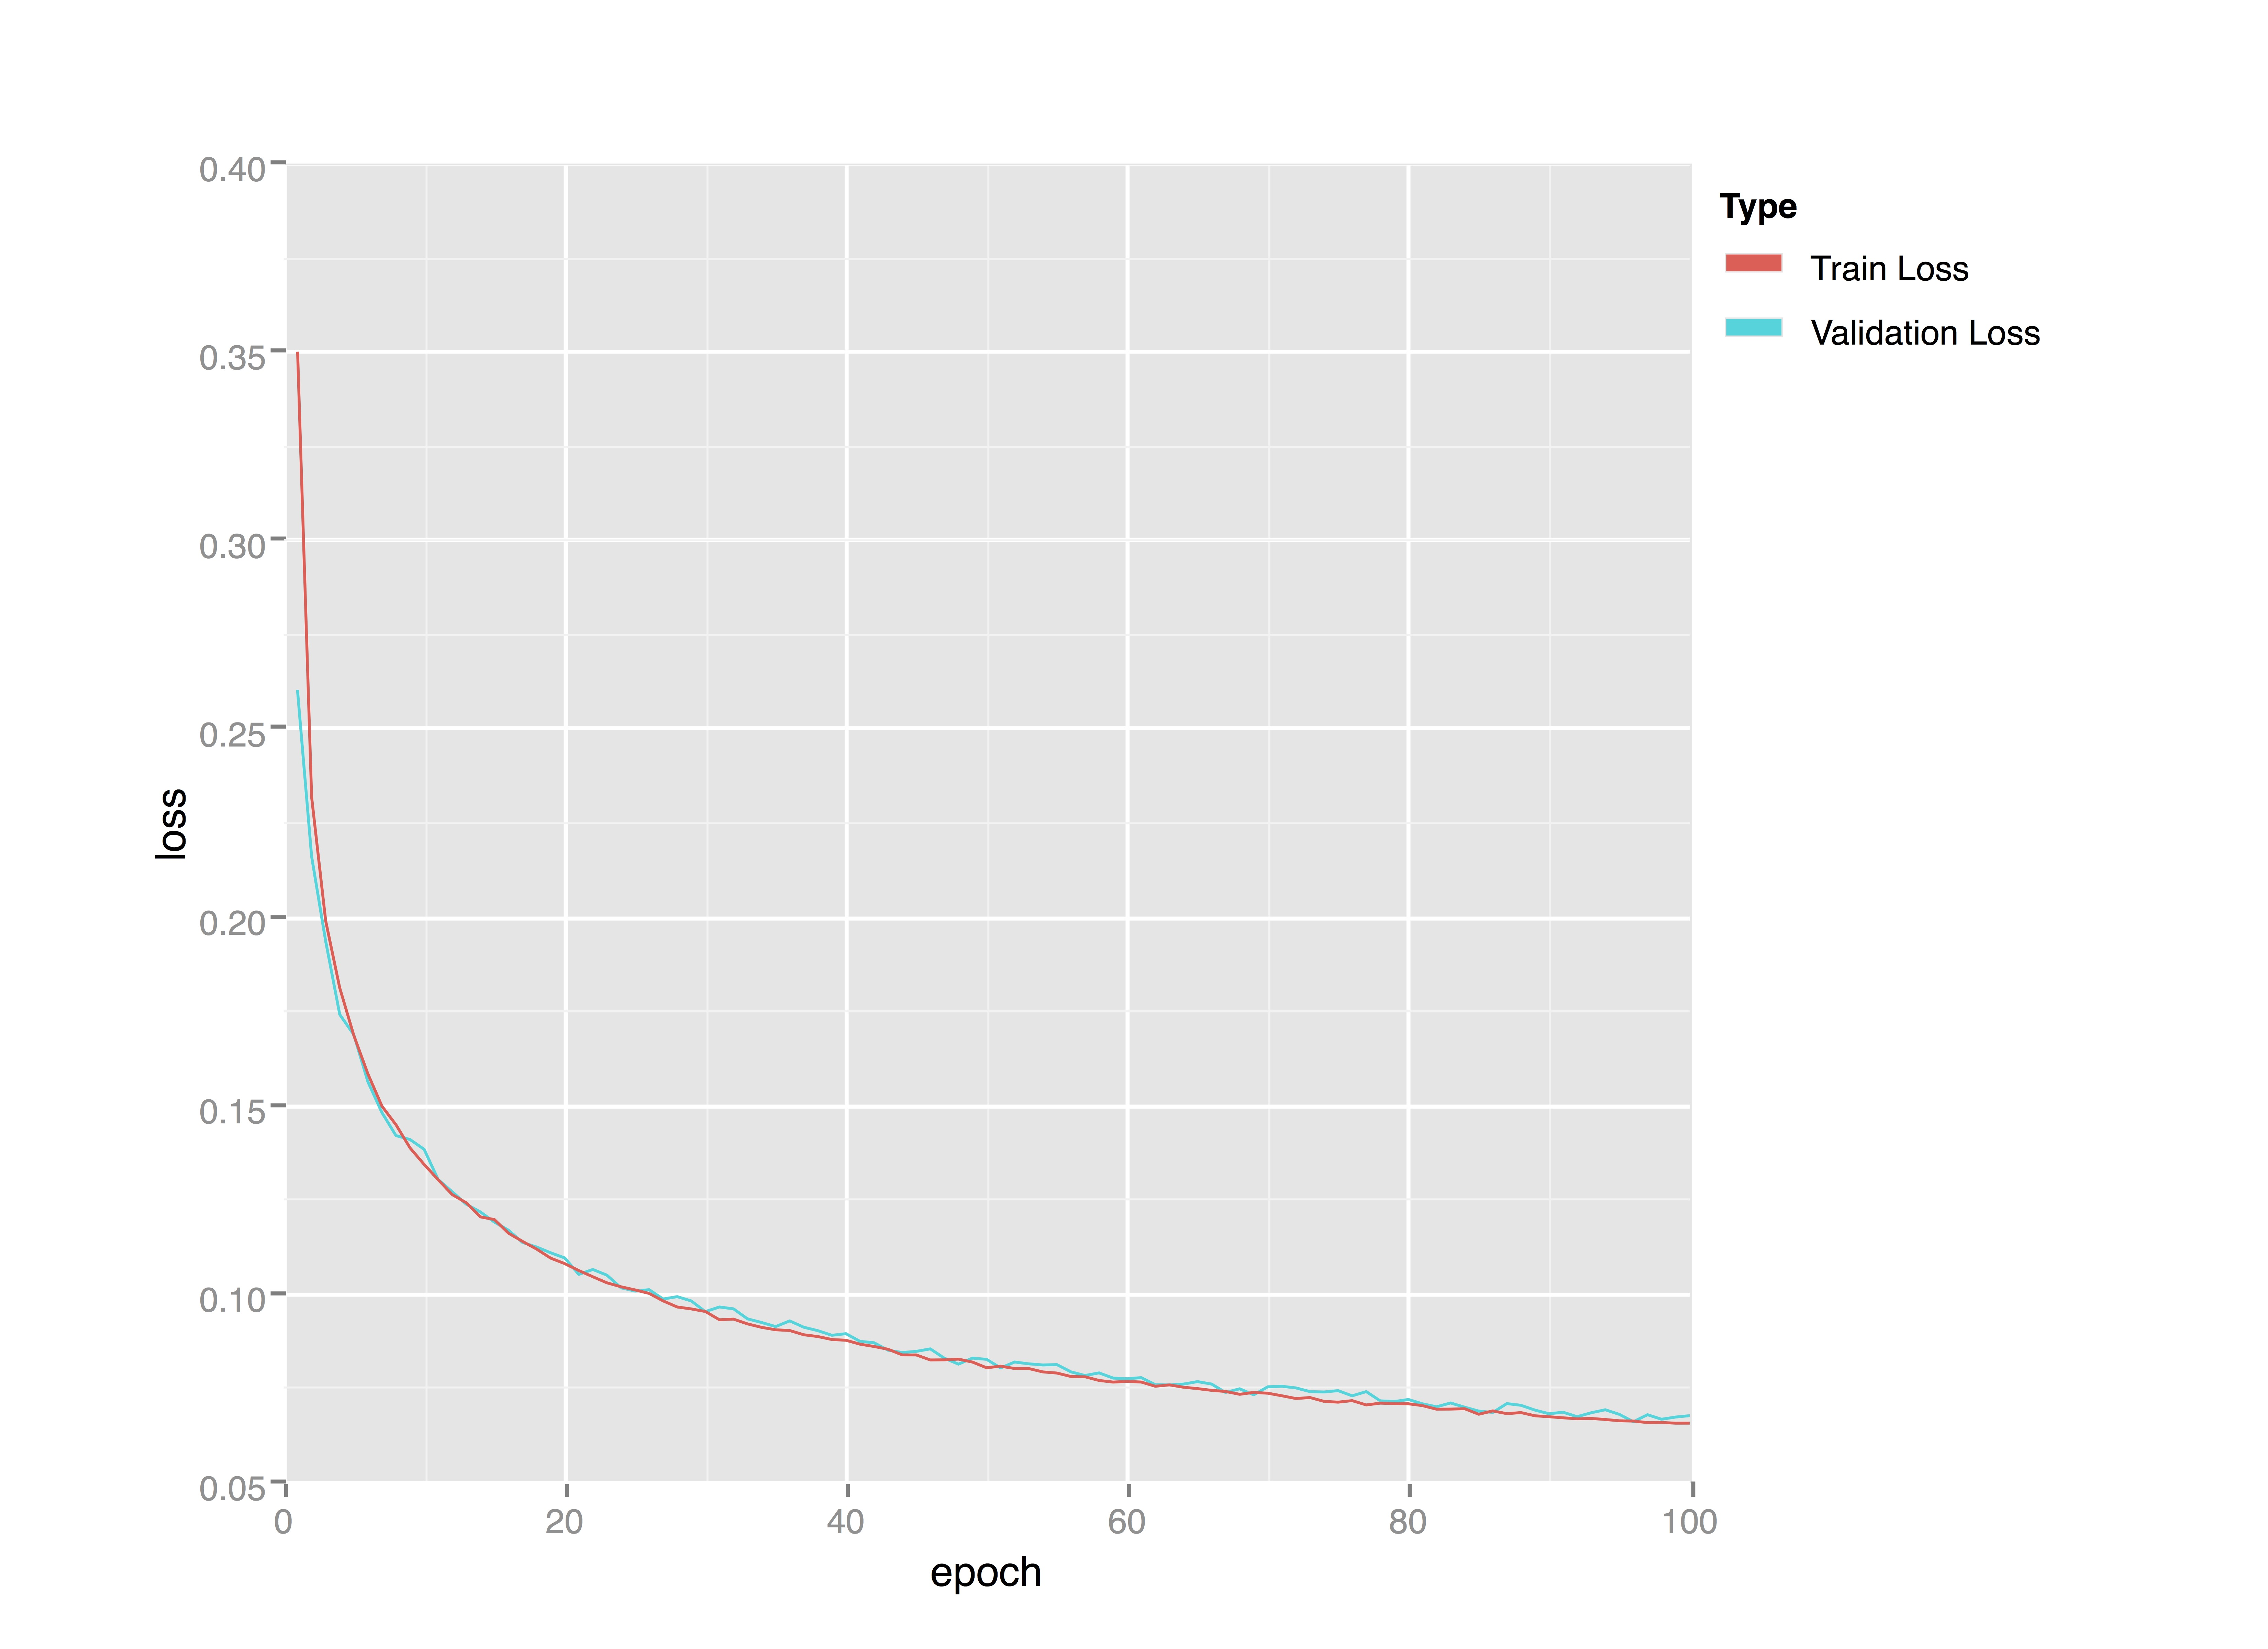

In [12]:
# show the loss decreasing with epoch
from IPython.display import Image
Image(filename='results/LinearNet_flic_2015-07-27-12-14-37/log_loss.jpg', width=900)

## Show the original picture and predict results

In [21]:
# Get some useful variables and reuse trans param above
data_dir = 'data/FLIC-full' # store image 
train_info_file = '%s/train_joints.csv' % data_dir  # store corrdinates of joints for training data
test_info_file = '%s/test_joints.csv' % data_dir  # store corrdinates of joints for test data
train_info = np.array([l.strip() for l in open(train_info_file).readlines()])
test_info = np.array([l.strip() for l in open(test_info_file).readlines()])
N_train = len(train_info)
N_test = len(test_info)
N = 5  # How many pictures to show
train_show = train_info[np.random.choice(N_train, N, replace=False)]
test_show = test_info[np.random.choice(N_test, N, replace=False)]
print 'Total number of train datasets: %d' % N_train
print 'Total number of test datasets: %d' % N_test
print 'Total number of test pictures: %d' % N

Total number of train datasets: 17380
Total number of test datasets: 3548
Total number of test pictures: 5


<a name='show_joints'></a>
## Show the images with joints
- The first row is the original images with ground truth joints
- The second row is the transformed images (resize to 220x220) with transformed groud truth joints
- The third row is the transformed images with predict joints which is trained by transformed images

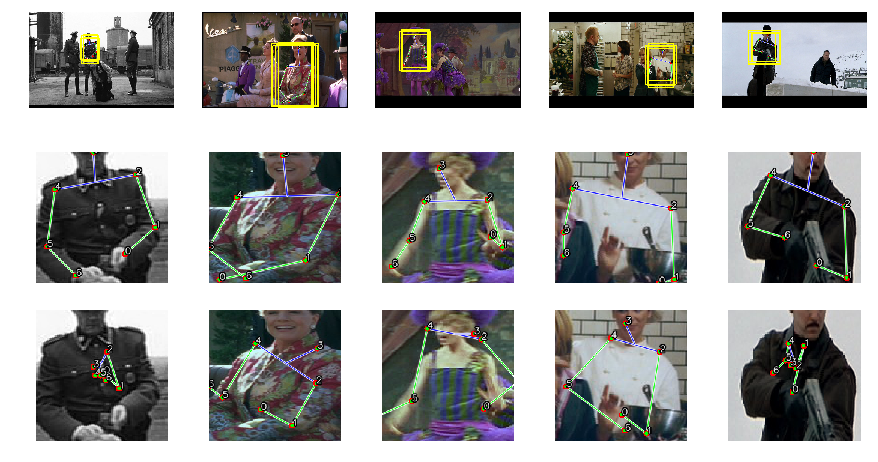

In [62]:
# Show training images
from my_scripts.test_flic_dataset import show_ori_trans_pred_joints
show_ori_trans_pred_joints(N, train_show, data_dir, trans, best_model)

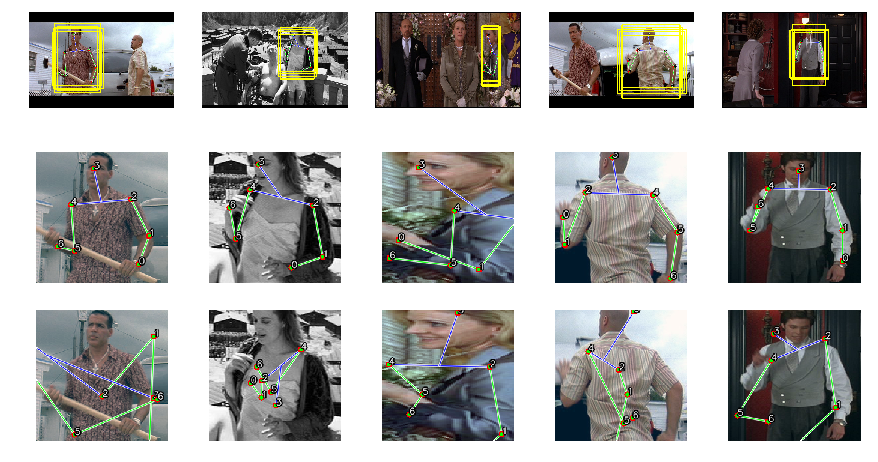

In [64]:
# Show test images
show_ori_trans_pred_joints(N, test_show, data_dir, trans, best_model)

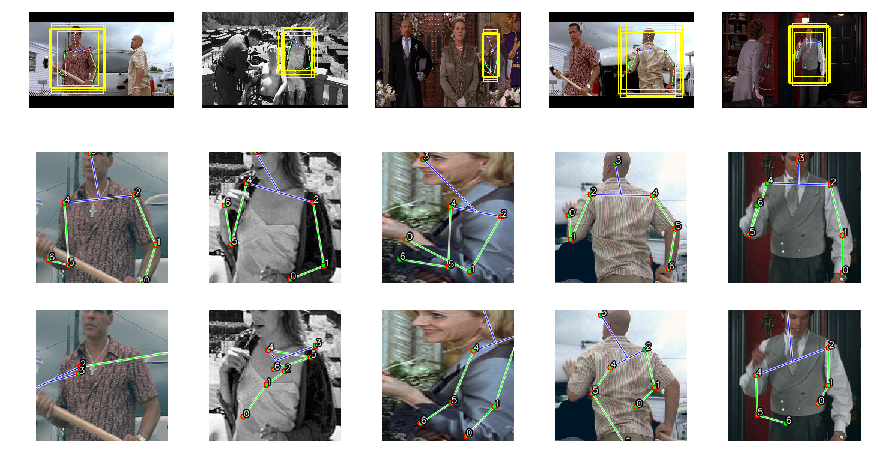

In [65]:
# show test images again to see the difference because of cropping noise
show_ori_trans_pred_joints(N, test_show, data_dir, trans, best_model)